In [43]:
import geopandas as gpd
from glob import glob
import os
import matplotlib.pyplot as plt
import mapping_funcs as mf
import pandas as pd
import rioxarray as rio
import cartopy.crs as ccrs
import xrspatial as xrs
import osmnx as ox
from matplotlib_scalebar.scalebar import ScaleBar

# https://data.humdata.org/dataset/areas-burned-from-february-3rd-to-18th-2024-around-the-pico-basil-volcano-on-bioko-island-

In [ ]:
files = glob('FR20240222GNQ_SHP/*/*.shp')

aoi = gpd.read_file(files[2]).loc[0,'geometry']

# get elevation and make hill shade. use utm projection of DEM
dem = mf.DEM.get_copernicus_dem(aoi, res=30, rprj=True)
hs = xrs.hillshade(dem)
prj = ccrs.epsg(dem.rio.crs.to_epsg())

# read in other data 
b1 = gpd.read_file(files[1], columns=['SensorDate','geometry'])
b2 = gpd.read_file(files[3], columns=['Sensor_Dat','geometry']).rename(columns={'Sensor_Dat':'SensorDate'})
damage = gpd.read_file(files[-1], columns='geometry')


In [88]:

# make legend label field and merge into single gdf
b1['note'] = 'Burned area: 2024-02-03'
b2['note'] = 'Burned area: 2024-02-18'
damage['note'] = 'potentially damaged buildings'

gdf = pd.concat([b2, b1, damage]).to_crs(prj)

# poi of volcano
volcano = ox.features_from_polygon(aoi, tags={'natural':'volcano'})[['name','geometry']].to_crs(prj)

c:\Users\s1759665\AppData\Local\miniforge-pypy3\envs\mapping\Lib\site-packages\pyproj\transformer.py:819: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(


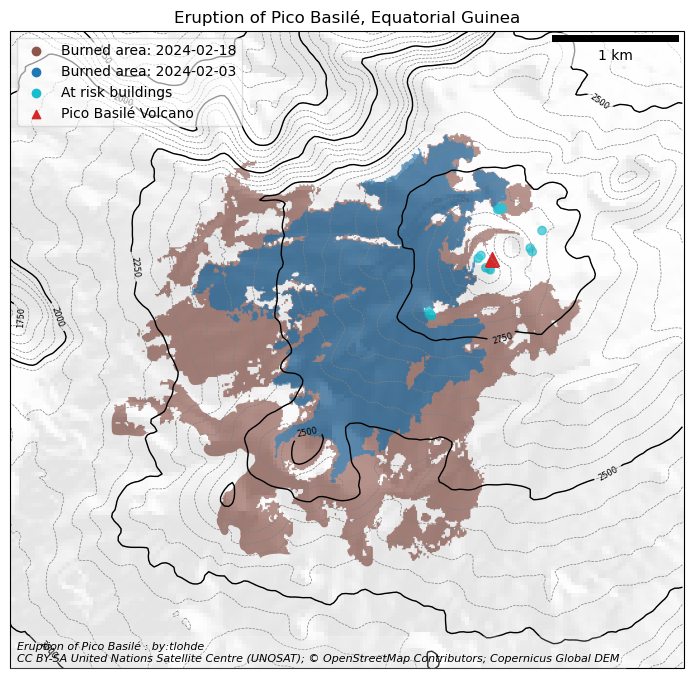

In [108]:
minx, miny, maxx, maxy = gdf.buffer(800).total_bounds

fig, ax = plt.subplots(subplot_kw={'projection':prj},
                       figsize=[11.69,8.27])

gdf.plot(column='note',
         cmap='tab10',
         alpha=0.7,
         zorder=1,
         ax=ax)

volcano.plot(ax=ax,
             marker='^',
             color='tab:red',
             markersize=100,
             legend=True,
             zorder=2)

dem.rio.clip_box(minx, miny, maxx, maxy).plot.contour(levels=range(0, 3000, 50),
                 colors='gray',
                 linewidths=0.5,
                 linestyles='--',
                 zorder=2,
                 ax=ax
                 )

contours = (dem
            .rio.clip_box(minx, miny, maxx, maxy)
            .plot.contour(levels=range(0, 3000, 250),
                          colors='k',
                          linewidths=1,
                          zorder=2,
                          ax=ax)
            )

ax.clabel(contours,
          inline=True,
          fontsize=6)

hs.plot(ax=ax,
        cmap='Grays',
        alpha=0.1,
        add_colorbar=False)

ax.set(xlim=(minx, maxx),
       ylim=(miny, maxy))

# dummy data for tidy legend
ax.scatter(0, 0,
           color='tab:brown',
           label='Burned area: 2024-02-18')
ax.scatter(0, 0,
           color='tab:blue',
           label='Burned area: 2024-02-03')
ax.scatter(0, 0,
           color='tab:cyan',
           label='At risk buildings')
ax.scatter(0, 0,
           color='tab:red',
           marker='^',
           label='Pico Basilé Volcano')

ax.legend(loc='upper left',
          #   frameon=False
          framealpha=0.6
          )

ax.add_artist(ScaleBar(1, location='upper right', box_alpha=0.6))

ax.set_title('Eruption of Pico Basilé, Equatorial Guinea')

ax.annotate('Eruption of Pico Basilé : by:tlohde\nCC BY-SA United Nations Satellite Centre (UNOSAT); © OpenStreetMap Contributors; Copernicus Global DEM',
            xy=(0.01,0.01),
            xycoords='axes fraction',
            fontsize=8,
            fontstyle='italic',
            backgroundcolor='w',
            bbox={'alpha':0.2, 'color':'w'}
            )

fig.savefig('day8.png', dpi=300, bbox_inches='tight')